In [2]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count, Sum
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.forms.models import model_to_dict

from scoping.models import *
from tmv_app.models import *
from scipy import stats
import ipy_table as tbl

run_id = 181
qid = 1281

In [3]:
docs = Doc.objects.filter(query=qid)

In [9]:
calc_sizes = True
if calc_sizes:
    topic_sizes = {}
    docs = Doc.objects.filter(query=qid,doctopic__isnull=False).distinct('UT')
    for doc in docs.iterator():
        t = doc.doctopic_set.filter(run_id=run_id).order_by('-score').first()
        try:
            topic_sizes[t.topic.title] +=1
        except:
            topic_sizes[t.topic.title] = 1

    print(topic_sizes)

    for key in topic_sizes:
        print(key)
        value = topic_sizes[key]
        topic = Topic.objects.get(run_id=run_id,title=key)
        topic.size = value
        print(topic.size)
        topic.save()

{'{transit, rail, station}': 254, '{bus, servic, oper}': 249, '{toll, lane, link}': 190, '{bicycl, cycl, cyclist}': 153, '{treatment, wastewat, plant}': 270, '{urban, land, citi}': 321, '{recycl, household, collect}': 205, '{price, congest, road}': 342, '{air, pollut, qualiti}': 229, '{emiss, carbon, ghg}': 383, '{brt, bus, system}': 77, '{travel, mode, choic}': 332, '{polici, instrument, effect}': 129, '{vehicl, electr, charg}': 269, '{climat, chang, mitig}': 176, '{heat, thermal, comfort}': 471, '{energi, build, consumpt}': 779, '{wast, manag, solid}': 517, '{green, build, roof}': 165, '{activ, school, health}': 414, '{park, space, price}': 236, '{develop, sustain, plan}': 898, '{model, network, optim}': 435, '{transport, public, access}': 295, '{water, heat, suppli}': 145}
{transit, rail, station}
254
{bus, servic, oper}
249
{toll, lane, link}
190
{bicycl, cycl, cyclist}
153
{treatment, wastewat, plant}
270
{urban, land, citi}
321
{recycl, household, collect}
205
{price, congest, ro

In [10]:
topic_sizes = list(Topic.objects.filter(run_id=run_id).values('title','size'))
topics = pd.DataFrame.from_dict(list(topic_sizes)).rename(columns={'title':'topic','size':'topic_size'})
topics.head()

,topic_size,topic
0,321,"{urban, land, citi}"
1,236,"{park, space, price}"
2,254,"{transit, rail, station}"
3,269,"{vehicl, electr, charg}"
4,205,"{recycl, household, collect}"


In [13]:
tvalues = []
dns = 0
for d in docs:
    
    ns = [x for x in re.findall("[^0-9]+([2-3{1}][0-9]{3})[^0-9]+",d.content) if int(x) > 2017 and int(x) < 2101]
    if len(ns) > 0:
        dns+=1
        t = d.doctopic_set.filter(run_id=run_id).order_by('-score').first()
        for n in ns:
            v = {
                "doc" : d.UT,
                "topic" : t.topic.title,
                "topic_size" : t.topic.size,
                "number" : n,
                "abstract": d.content
            }
            tvalues.append(v)
            
print(dns)

282


In [14]:
df = pd.DataFrame.from_dict(list(tvalues))
df['number'] = pd.to_numeric(df['number'])
df.head()
len(df)

374

In [21]:
pdf = df[['topic','number']]
g = pdf.groupby('topic').agg(['median','count']).sort_values(('number','median'))
print(g.head())
g['topic'] = g.index
g = g.reset_index(drop=True)
g['order'] = g.index
g.columns = g.columns.get_level_values(0) + "_" + g.columns.get_level_values(1)
g = g.rename(columns={"topic_":"topic","order_":"order"})


g['topic_label'] = g.apply(lambda x: "{} [{}]".format(x['topic'], (x['number_count'])) , axis=1)

pdf = pd.merge(pdf,g[['topic','order']])
pdf['topic'] = pdf.apply(lambda x: "{:02d} {}".format(x['order'], x['topic']) , axis=1)

                             number      
                             median count
topic                                    
{model, network, optim}      2020.0     3
{vehicl, electr, charg}      2020.0    26
{energi, build, consumpt}    2020.5    84
{bus, servic, oper}          2021.0     1
{transport, public, access}  2024.5    16


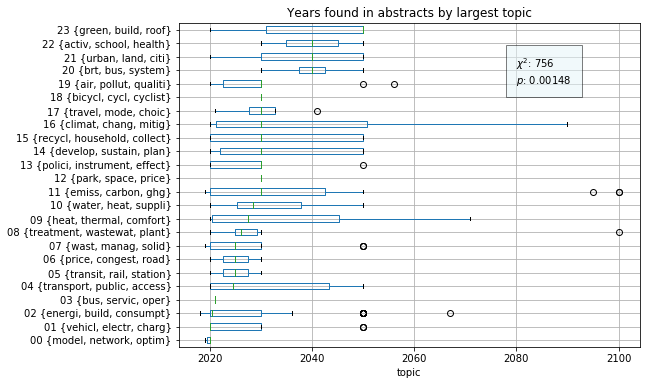

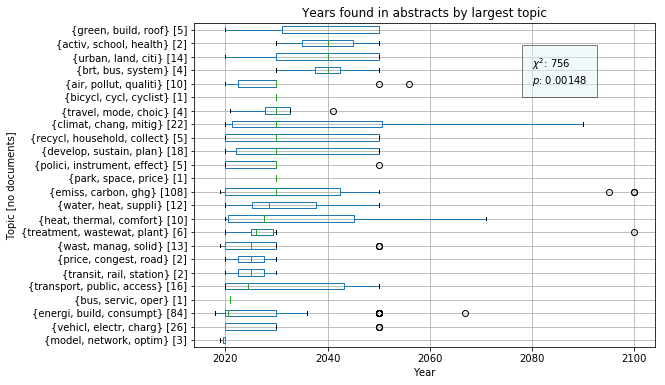

In [22]:
import matplotlib.pyplot as plt
crosstab = pd.crosstab(df['topic'],df['number'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab.values)

#tbl.make_table(results)
plt.rcParams["figure.figsize"] = [8,6]
pdf.boxplot(column='number', by='topic', vert=False)
plt.savefig('../plots/topic_years.png',bbox_inches='tight')  

plt.text(
    2080,20,'$\chi^2$: {0:.3g}\n$p$: {1:.3g}'.format(chi2,p),
    bbox={'facecolor':'#e5f5f9', 'alpha':0.5, 'pad':10}
)

plt.title('Years found in abstracts by largest topic')
plt.suptitle('')

#fig, ax = plt.subplots()
plt.yticks(g.index+1,g.topic_label)
plt.xlabel('Year')
plt.ylabel('Topic [no documents]')

plt.savefig('../plots/topic_years.png',bbox_inches='tight')
plt.show()



In [18]:
df.to_csv("../data/years.csv")

In [19]:
g = df[['topic','number']].groupby(['topic'], as_index=False)
g = g.agg(['median','mean',np.std, 'count'], as_index=False).rename(columns={'std': 'std dev'}).reset_index()
g.columns = g.columns.get_level_values(0) + "_" + g.columns.get_level_values(1)
g = g.rename(columns={'topic_':'topic'}).sort_values('number_median')

topic_summary = pd.merge(g,topics,how='right')
print(topic_summary)
topic_summary.to_csv("../data/year_summaries.csv")

                           topic  number_median  number_mean  number_std dev  \
0        {model, network, optim}         2020.0  2019.666667        0.577350   
1        {vehicl, electr, charg}         2020.0  2025.961538        9.763117   
2      {energi, build, consumpt}         2020.5  2028.000000       11.114952   
3            {bus, servic, oper}         2021.0  2021.000000             NaN   
4    {transport, public, access}         2024.5  2031.312500       13.001122   
5       {transit, rail, station}         2025.0  2025.000000        7.071068   
6         {price, congest, road}         2025.0  2025.000000        7.071068   
7           {wast, manag, solid}         2025.0  2029.000000       12.456591   
8   {treatment, wastewat, plant}         2026.0  2037.833333       30.629506   
9       {heat, thermal, comfort}         2027.5  2033.900000       17.381024   
10         {water, heat, suppli}         2028.5  2031.916667       10.689488   
11          {emiss, carbon, ghg}        